<a href="https://colab.research.google.com/github/Joshuazhou2020/CMEMTransportSystem/blob/master/CMEMTransportSystemV1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# CMEMTransportSystemV1.0

  * Train model  `LinearRegressor` class in TensorFlow by using it to predict  voltage and speed, at the granularity of x, t, y
  * Use a validation data set and test set to make sure that our model will generalize and is not overfitting the training data.
  * Use test data only after tuning hyperparameters as a measure of how the model will generalize to new data
  * [TBD] Create synthetic features from the existing features 
  * [TBD] More practice with feature transformations including identifying and clipping (removing) outliers out of the input data to obtain the best model

Reference:
https://research.google.com/seedbank/seed/5730827476402176


### Standard Set-up

We begin with the same set-up as in the last lab.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error. You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


Read the data and randomize the order.

In [0]:
!pip install --upgrade -q gspread
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

**Open Training Data**


**Load Test data**

In [36]:
#test_data 
#dataUrl="https://docs.google.com/spreadsheets/d/1o8kPJ4znCkSNA89-AmLVTFoodQzFyxnlf6pSOtQMWNw/edit#gid=1683593853"

#starter_plastic_magnet
#dataUrl="https://docs.google.com/spreadsheets/d/1A3W1thd6JHuuVD3CyXXqsDApIhlonA63n_f3wXzQjH8/edit#gid=1532774856"

#p2_magnet
#dataUrl="https://docs.google.com/spreadsheets/d/1QmlkQ3j_-tcCQ1zZXg4syLzRYzA2iDl0Zt4MtRJ7-hg/edit#gid=1183274326"

#p3_magnet
#dataUrl="https://docs.google.com/spreadsheets/d/1R_A0BgGRT4YjlickBRFirnBWeNMvOTOCeOp5DuoA97Y/edit#gid=1100098390"

#p4_magnet
#dataUrl="https://docs.google.com/spreadsheets/d/1L_WyVf3dTn1jM5hKcSJ1KhydW1iKa_6-zuzr6yhU_pU/edit#gid=1100098390"

#p5_magnet
dataUrl="https://docs.google.com/spreadsheets/d/1U0Laa50JcK3fplgEW0I2VWSI-Td4Tda9pCPtTlvKvxk/edit#gid=1183274326"

#p1d_magnet
dataUrl="https://docs.google.com/spreadsheets/d/1R1W6nuDgp8lw2ArxMbRRM_defKssJvziKGTEqQ9uRl4/edit#gid=1183274326"

PREDICT_V_COLUMN='D1:D'
PREDICT_S_COLUMN='E1:E'

COLUMNS=["x","t","y","v","s","xplusy","xminusy"]



head=28
tail=28


#worksheet = gc.open_by_url(dataUrl).worksheet("test_"+label+"_data")
worksheet = gc.open_by_url(dataUrl).worksheet("test_data")

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()

# Convert to a DataFrame and render.
import pandas as pf

df=pf.DataFrame.from_records(rows)
df.columns = COLUMNS
df.apply(pf.to_numeric)

df["x"] = df.x.astype(float)
df["t"] = df.t.astype(float)
df["y"] = df.y.astype(float)
df["v"] = df.v.astype(float)
df["s"] = df.s.astype(float)
df["xplusy"] = df.xplusy.astype(float)
df["xminusy"] = df.xminusy.astype(float)


print df;

df = df.reindex(np.random.permutation(df.index))
df.describe()

df.info()






        x     t      y     v     s  xplusy  xminusy
0   15.00 10.00   0.00 44.90  1.00   15.00    15.00
1   15.00 10.00  15.00 41.60  1.00   30.00     0.00
2   15.00 10.00  25.00 39.60  1.00   40.00   -10.00
3   15.00 10.00  50.00 34.50 -1.00   65.00   -35.00
4   15.00 10.00  75.00 30.00 -1.00   90.00   -60.00
5   15.00 10.00 100.00 26.10 -1.00  115.00   -85.00
6   15.00 15.00   0.00 45.10  1.00   15.00    15.00
..    ...   ...    ...   ...   ...     ...      ...
53 100.00 10.00 100.00 17.70 -1.00  200.00     0.00
54 100.00 15.00   0.00 28.20 -1.00  100.00   100.00
55 100.00 15.00  15.00 27.20 -1.00  115.00    85.00
56 100.00 15.00  25.00 24.90  0.00  125.00    75.00
57 100.00 15.00  50.00 23.30 -1.00  150.00    50.00
58 100.00 15.00  75.00 20.65  1.00  175.00    25.00
59 100.00 15.00 100.00 17.50  0.00  200.00     0.00

[60 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 60 entries, 23 to 49
Data columns (total 7 columns):
x          60 non-null float64
t          

In [37]:
# Open our new sheet and read some data.
#worksheet2 = gc.open_by_url(dataUrl).worksheet("test_"+label+"_data")
worksheet2 = gc.open_by_url(dataUrl).worksheet("test_data")

# get_all_values gives a list of rows.
rows2 = worksheet2.get_all_values()
#print(rows)

# Convert to a DataFrame and render.
import pandas as pf
test_examples = pf.DataFrame.from_records(rows2)
test_examples.apply(pf.to_numeric)
#test_examples.columns = test_examples.iloc[0]
test_examples.columns = COLUMNS

test_examples["x"] = test_examples.x.astype(float)
test_examples["t"] = test_examples.t.astype(float)
test_examples["y"] = test_examples.y.astype(float)
test_examples["v"] = test_examples.v.astype(float)
test_examples["s"] = test_examples.s.astype(float)
test_examples["xplusy"] = test_examples.xplusy.astype(float)
test_examples["xminusy"] = test_examples.xminusy.astype(float)

print test_examples

test_examples.describe()

test_examples.info()


        x     t      y     v     s  xplusy  xminusy
0   15.00 10.00   0.00 44.90  1.00   15.00    15.00
1   15.00 10.00  15.00 41.60  1.00   30.00     0.00
2   15.00 10.00  25.00 39.60  1.00   40.00   -10.00
3   15.00 10.00  50.00 34.50 -1.00   65.00   -35.00
4   15.00 10.00  75.00 30.00 -1.00   90.00   -60.00
5   15.00 10.00 100.00 26.10 -1.00  115.00   -85.00
6   15.00 15.00   0.00 45.10  1.00   15.00    15.00
..    ...   ...    ...   ...   ...     ...      ...
53 100.00 10.00 100.00 17.70 -1.00  200.00     0.00
54 100.00 15.00   0.00 28.20 -1.00  100.00   100.00
55 100.00 15.00  15.00 27.20 -1.00  115.00    85.00
56 100.00 15.00  25.00 24.90  0.00  125.00    75.00
57 100.00 15.00  50.00 23.30 -1.00  150.00    50.00
58 100.00 15.00  75.00 20.65  1.00  175.00    25.00
59 100.00 15.00 100.00 17.50  0.00  200.00     0.00

[60 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
x          60 non-null float64
t          6

**Load Predict data**

In [38]:

startX=5
stepX=5
maxX=100
stepXNum = (maxX-startX)/stepX+1;

startT=1
stepT=4
maxT=5
stepTNum = (maxT-startT)/stepT+1;

startY=5
stepY=5
maxY=100
stepYNum = (maxY-startY)/stepY+1;


# Open our new sheet and read some data.
#worksheet3 = gc.open_by_url(dataUrl).worksheet("predict_"+label+"_data")
worksheet3 = gc.open_by_url(dataUrl).worksheet("predict_data")

index=0
x=0
print stepXNum*stepTNum*stepYNum*4

cell_list = worksheet3.range('A1:G'+str(stepXNum*stepTNum*stepYNum*4))
                             
while x < stepXNum:
  #print "x="+str(x)
  t=0
  while t < stepTNum:
    #print "t="+str(t)
    y=0
    while y < stepYNum:              
      #print "y="+str(y)
      cell_list[index].value = startX+stepX*(x)
      cell_list[index+1].value = startT+stepT*(t)
      cell_list[index+2].value = startY+stepY*(y)
      cell_list[index+3].value = 0
      cell_list[index+4].value = 0
      cell_list[index+5].value = cell_list[index].value + cell_list[index+2].value
      cell_list[index+6].value = cell_list[index].value - cell_list[index+2].value
      index += 7
      #print "index="+str(index)
      y += 1
    t += 1
  x += 1

#update in batch
worksheet3.update_cells(cell_list);

# get_all_values gives a list of rows.
rows3 = worksheet3.get_all_values()



# Convert to a DataFrame and render.
import pandas as pf
prediction_examples = pf.DataFrame.from_records(rows3)
prediction_examples.apply(pf.to_numeric)
prediction_examples.columns = COLUMNS

prediction_examples["x"] = prediction_examples.x.astype(float)
prediction_examples["t"] = prediction_examples.t.astype(float)
prediction_examples["y"] = prediction_examples.y.astype(float)
prediction_examples["v"] = prediction_examples.v.astype(float)
prediction_examples["s"] = prediction_examples.s.astype(float)
prediction_examples["xplusy"] = prediction_examples.xplusy.astype(float)
prediction_examples["xminusy"] = prediction_examples.xminusy.astype(float)


prediction_examples.describe()

prediction_examples.info()

print prediction_examples


def predict_input_fn():
  return input_fn(prediction_examples)

3200
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 7 columns):
x          800 non-null float64
t          800 non-null float64
y          800 non-null float64
v          800 non-null float64
s          800 non-null float64
xplusy     800 non-null float64
xminusy    800 non-null float64
dtypes: float64(7)
memory usage: 43.8 KB
         x    t      y    v    s  xplusy  xminusy
0     5.00 1.00   5.00 0.00 0.00   10.00     0.00
1     5.00 1.00  10.00 0.00 0.00   15.00    -5.00
2     5.00 1.00  15.00 0.00 0.00   20.00   -10.00
3     5.00 1.00  20.00 0.00 0.00   25.00   -15.00
4     5.00 1.00  25.00 0.00 0.00   30.00   -20.00
5     5.00 1.00  30.00 0.00 0.00   35.00   -25.00
6     5.00 1.00  35.00 0.00 0.00   40.00   -30.00
..     ...  ...    ...  ...  ...     ...      ...
793 100.00 5.00  70.00 0.00 0.00  170.00    30.00
794 100.00 5.00  75.00 0.00 0.00  175.00    25.00
795 100.00 5.00  80.00 0.00 0.00  180.00    20.00
796 100.00 5.00  85.00 0.0

##Prepare Features

As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. You will change this later in the lab. For now this method will just make a copy of the portion of the dataframe we plan to use, and re-scale the median-house value (to make it a bit easier to work with).

In [0]:
def prepare_features(df):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = df.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  # processed_features["median_house_value"] /= 1000.0
  
  return processed_features

###Divide the provided data for training our model into a training and validation set

As in the last lab we use the first 14000 examples (after randomization) for the ***training set*** and the remaining 3000 examples for the ***validation set***.

In [40]:
import pandas as pf

training_examples = prepare_features(df.head(head))
validation_examples = prepare_features(df.tail(tail))
training_examples.describe()

training_examples.apply(pf.to_numeric)
validation_examples.apply(pf.to_numeric)

print training_examples
print validation_examples


       x     t      y     v     s  xplusy  xminusy
23 25.00 15.00 100.00 25.90 -1.00  125.00   -75.00
1  15.00 10.00  15.00 41.60  1.00   30.00     0.00
28 50.00 10.00  75.00 24.80 -1.00  125.00   -25.00
31 50.00 15.00  15.00 38.00 -1.00   65.00    35.00
27 50.00 10.00  50.00 32.00  1.00  100.00     0.00
4  15.00 10.00  75.00 30.00 -1.00   90.00   -60.00
43 75.00 15.00  15.00 30.30  1.00   90.00    60.00
..   ...   ...    ...   ...   ...     ...      ...
21 25.00 15.00  50.00 32.40  1.00   75.00   -25.00
16 25.00 10.00  75.00 28.20 -1.00  100.00   -50.00
25 50.00 10.00  15.00 34.70  1.00   65.00    35.00
6  15.00 15.00   0.00 45.10  1.00   15.00    15.00
7  15.00 15.00  15.00 41.60  1.00   30.00     0.00
17 25.00 10.00 100.00 27.10 -1.00  125.00   -75.00
14 25.00 10.00  25.00 37.10  1.00   50.00     0.00

[28 rows x 7 columns]
        x     t      y     v     s  xplusy  xminusy
51 100.00 10.00  50.00 23.20  0.04  150.00    50.00
32  50.00 15.00  25.00 32.90 -1.00   75.00    25.00
58 10

### Compute Loss

Here is a simple method to compute the loss on the given input function and targets.

In [0]:
def compute_loss(model, input_fn, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    model: the trained model to use for making the predictions.
    input_fn: the input_fn to use to make the predictions.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets.
  """      
  
  predictions = list(model.predict(input_fn=input_fn))
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

### Setting Up the Feature Columns and Input Function for TensorFlow
As in the last lab we define `input_fn` to create a real-valued feature for each provided
numerical column, and then define `train_input_fn` to use the training data, `eval_input_fn` to use the validation data, and `test_input_fn` to use the test data.

In [0]:
CATEGORICAL_COLUMNS = []

def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(training_examples)

def eval_input_fn():
  return input_fn(validation_examples)

def test_input_fn():
  return input_fn(test_examples)


### Functions to help visualize our results

We will use our functions from the last lab to generate a calibration plot and learning curve (with both training and validation losses).

In [0]:
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of training losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)



Defining the features, linear regression model, and function to train the model

These functions are just like the last lab except now we include all of the available numerical features.

In [0]:


def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features.
  
  Returns:
    A set of feature columns.
  """
  
  feature_set = set([tf.contrib.layers.real_valued_column(feature) 
                     for feature in NUMERICAL_FEATURES])
  return feature_set

def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear regressor created with the given parameters.
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train.
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained regressor.
  """
  # In order to see how the model evolves as we train it, we divide the
  # steps into periods and show the model after each period.
  

  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training and validation losses so we can
  # generate a learning curve.
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps.
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)
    # Compute the loss between the predictions and the correct labels, append
    # the training and validation loss to the list of losses used to generate
    # the learning curve after training is complete and print the current
    # training loss.
    
    training_loss = compute_loss(linear_regressor, train_input_fn,
                                 training_examples[LABEL])
    validation_loss = compute_loss(linear_regressor, eval_input_fn,
                                   validation_examples[LABEL])
    training_losses.append(training_loss) 
    validation_losses.append(validation_loss) 
    print "  Training loss after period %02d : %0.3f" % (period, training_loss)
      
  # Now that training is done print the final training and validation losses.    
  print "Final Training Loss (RMSE): %0.3f" % training_loss
  print "Final Validation Loss (RMSE): %0.3f" % validation_loss 
  
  # Generate a figure with the learning curve on the left and a
  # calibration plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("Calibration Plot on Validation Data")
  validation_predictions = np.array(list(linear_regressor.predict(
      input_fn=eval_input_fn)))
  make_calibration_plot(validation_predictions, validation_examples[LABEL])
   
  return linear_regressor

### Training a model with one feature.

In the last lab, you trained a model to predict the `median_house_value` from a single feature. Before we explore what can be done by introducing additional features, let's just train a good model to use a single feature.  Feel free to change the below, but as is it should give a pretty good result (given the constraint of using a single feature).

['xplusy']
v
  Training loss after period 00 : 17.401
  Training loss after period 01 : 14.059
  Training loss after period 02 : 11.370
  Training loss after period 03 : 9.210
  Training loss after period 04 : 7.478
  Training loss after period 05 : 6.094
  Training loss after period 06 : 4.991
  Training loss after period 07 : 4.119
  Training loss after period 08 : 3.435
  Training loss after period 09 : 2.906
Final Training Loss (RMSE): 2.906
Final Validation Loss (RMSE): 2.477
loss on test data V is 2.67581850675
['x', 't', 'y']
s
  Training loss after period 00 : 0.763
  Training loss after period 01 : 0.763
  Training loss after period 02 : 0.763
  Training loss after period 03 : 0.763
  Training loss after period 04 : 0.763
  Training loss after period 05 : 0.763
  Training loss after period 06 : 0.763
  Training loss after period 07 : 0.763
  Training loss after period 08 : 0.763
  Training loss after period 09 : 0.762
Final Training Loss (RMSE): 0.762
Final Validation Loss (RM

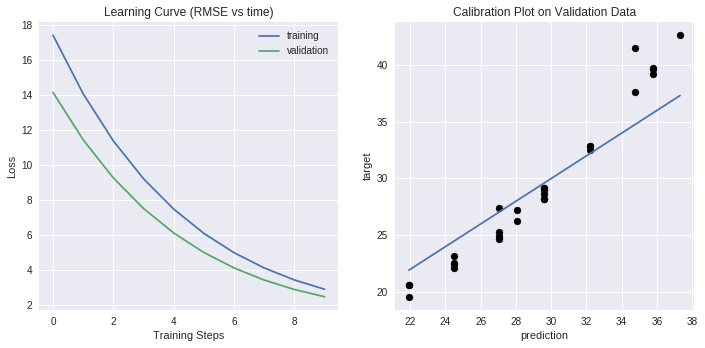

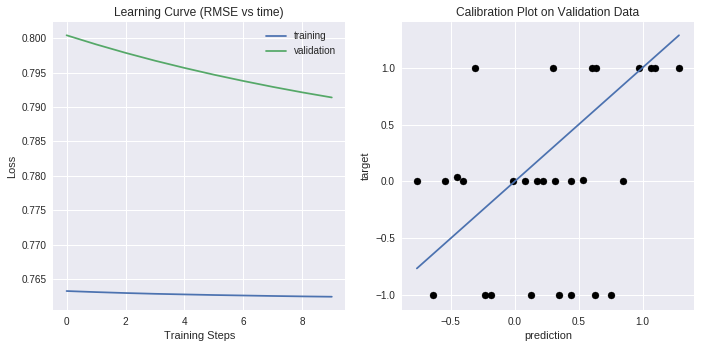

In [45]:
# Good one close to 5-6 for V
#LEARNING_RATE = 0.001
#STEPS = 25000

#Final Training Loss (RMSE): 6.378
#Final Validation Loss (RMSE): 4.492
LEARNING_RATE = 0.001
STEPS = 50000

NUMERICAL_COLUMNS = ["xplusy"]
NUMERICAL_FEATURES = ["xplusy"]
LABEL = "v"

print NUMERICAL_COLUMNS
print LABEL

linear_regressorV = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressorV = train_model(linear_regressorV, steps=STEPS)

print "loss on test data V is", compute_loss(
    linear_regressorV, test_input_fn, test_examples[LABEL])

#Final Training Loss (RMSE): 6.378
#Final Validation Loss (RMSE): 4.492
LEARNING_RATES = 0.001
STEPSS = 50000

NUMERICAL_COLUMNS = ["x","t","y"]
NUMERICAL_FEATURES = ["x","t","y"]
LABEL = "s"

print NUMERICAL_COLUMNS
print LABEL


linear_regressorS = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressorS = train_model(linear_regressorS, steps=STEPS)

print "loss on test data S is", compute_loss(
    linear_regressorS, test_input_fn, test_examples[LABEL])


Predict and write the prediction to googe sheet

In [46]:
print "Prdecit....."
print "prediction examples..."
print prediction_examples


#Predict Voltage
NUMERICAL_COLUMNS = ["xplusy"]
NUMERICAL_FEATURES = ["xplusy"]
LABEL = "v"

predictionsV=np.array(list(linear_regressorV.predict(
      input_fn=predict_input_fn)))

cell_listV = worksheet3.range(PREDICT_V_COLUMN+str(len(predictionsV)))

i = 0
while i < len(predictionsV):
    cell_listV[i].value = str(predictionsV[i]);
    i += 1
    
worksheet3.update_cells(cell_listV);


#Predict Speed
NUMERICAL_COLUMNS = ["x","t","y"]
NUMERICAL_FEATURES = ["x","t","y"]
LABEL = "s"

predictionsS=np.array(list(linear_regressorS.predict(
      input_fn=predict_input_fn)))

cell_listS = worksheet3.range(PREDICT_S_COLUMN+str(len(predictionsS)))

i = 0
while i < len(predictionsS):
    cell_listS[i].value = str(predictionsS[i]);
    i += 1
    
# Update in batch
worksheet3.update_cells(cell_listS);


#print cell_list  
print "voltage result..."
print predictionsV
print "speed result..."
print predictionsS

Prdecit.....
prediction examples...
         x    t      y    v    s  xplusy  xminusy
0     5.00 1.00   5.00 0.00 0.00   10.00     0.00
1     5.00 1.00  10.00 0.00 0.00   15.00    -5.00
2     5.00 1.00  15.00 0.00 0.00   20.00   -10.00
3     5.00 1.00  20.00 0.00 0.00   25.00   -15.00
4     5.00 1.00  25.00 0.00 0.00   30.00   -20.00
5     5.00 1.00  30.00 0.00 0.00   35.00   -25.00
6     5.00 1.00  35.00 0.00 0.00   40.00   -30.00
..     ...  ...    ...  ...  ...     ...      ...
793 100.00 5.00  70.00 0.00 0.00  170.00    30.00
794 100.00 5.00  75.00 0.00 0.00  175.00    25.00
795 100.00 5.00  80.00 0.00 0.00  180.00    20.00
796 100.00 5.00  85.00 0.00 0.00  185.00    15.00
797 100.00 5.00  90.00 0.00 0.00  190.00    10.00
798 100.00 5.00  95.00 0.00 0.00  195.00     5.00
799 100.00 5.00 100.00 0.00 0.00  200.00     0.00

[800 rows x 7 columns]
voltage result...
[38.84212  38.329536 37.81695  37.304367 36.791786 36.2792   35.766617
 35.254036 34.74145  34.228867 33.716286 33.2037   